## Combining Ryan's patching codebase with Thinker's Epithelium width calculation

* The main change comes from new functon `calculate_patch_corners`, which takes and replaces Ryan's `calculate_square_corners` function and adds new logic that calculates the epithelium width using the normal line. It still returns corners and extended length to draw patches using Ryan's logic. 
    * However, by leveraging the epithelium width, we get rid of two parameters: `square_size` and `step`. These two parameters were necessary for the iterative style of patching, but is redundant with epithelium width calculated. 

* The new function `calculate_patch_corners` works by creating an array of step distances from 0 to some max_length in increments of step_size. It retrieves pixel values along the binary mask and stops at the first index where the pixel turns to background. Then we slightly extend the width to account for the stroma by a factor of extension_factor. 

* Everything else is relatively consistent with Ryan's original codebase, with some minor changes to eliminate iterations and `square_size` and `step` variables in other functions

In [2]:
import numpy as np
import cv2
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid


#Read image and threshold for mask:
#This basic method works best with already cropped cells
#I have another at the bottom that is slightly better for cells with backgrounds
image1=cv2.imread("h2114153  h&e_ROI_1 Epithelia copy.png")
image2 = cv2.imread('h2114155 h&e_ROI_1 Epithelia copy.png')
image3 = cv2.imread('h2114160 h&e_ROI_1 Epithelia copy.png')





image1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
_,whole_thresh=cv2.threshold(image1_gray,1,255,cv2.THRESH_BINARY)

In [6]:
def find_external_contours(binary_image):
    '''find all external contours of an image'''

    contours,hierarchy=cv2.findContours(binary_image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    #This can be used to alter the order contour points are processed in while maintaining order
        #Think [1,2,3,4,5]->[4,5,1,2,3]
        #Set to 0 for no effect, check np documentation for more info
    return [np.roll(contour,0,axis=0) for contour in contours]

def calculate_contour_normals(contours,smoothing_size=5):
    '''Calculate normal vector along contour points'''

    all_normals=[]
    
    #Loop over all contours in image
    for contour in contours:
        #Reshape into xy pairings
        points=contour.reshape(-1,2)
        n_points=len(points)
        tangents=np.zeros_like(points,dtype=float)

        #Calculate tangent using smoothing
        #Higher smoothingn values result in less "jutty" squares, but can work poorly on smaller regions of epithelium
        for i in range(n_points):
            prev_idx=(i-smoothing_size)%n_points
            next_idx=(i+smoothing_size)%n_points
            tangent=points[next_idx]-points[prev_idx]
            tangent=tangent/(np.linalg.norm(tangent)+1e-8)
            tangents[i]=tangent
            

        #Convert to normal
        normals=np.zeros_like(tangents)
        normals[:,0]=-tangents[:,1]
        normals[:,1]=tangents[:,0]
        
        #add to list of all contour normals
        all_normals.append(normals)

    return all_normals


def calculate_patch_corners(point, normal, binary_image, extension_factor=1.1, step_size=2, max_length=2048):
    """
    Calculate the corners of a square patch using epithelium width along the normal.

    Args:
        point (np.ndarray): The point on the contour.
        normal (np.ndarray): The normal vector at the point.
        binary_image (np.ndarray): Binary mask of the tissue.
        extension_factor (float): Factor to slightly enlarge the patch (e.g., 1.1 for 10% increase).
        step_size (int): Step size for checking tissue boundaries along the normal.
        max_length (int): Maximum distance to search for epithelium width.

    Returns:
        np.ndarray: The four corners of the square patch.
        int: The computed patch height.
    """
    height, width = binary_image.shape
    point = point.astype(int)

    # generating forward and backward points along the normal
    steps = np.arange(0, max_length, step_size)[:, None]
    points = np.clip(point - steps * normal, 0, [width - 1, height - 1]).astype(int)

    # extracting pixel values along the normal path
    values = binary_image[points[:, 1], points[:, 0]]

    # finding the first background pixel (where value == 0)
    stop = np.where(values == 0)[0]

    # computing distances
    width = stop[0] * step_size if stop.size > 0 else max_length

    # computing total epithelium width and adjust for stroma extension
    extended_length = int(width * extension_factor)
    half_size = extended_length // 2 

    # computing tangent vector (perpendicular to normal)
    tangent = np.array([-normal[1], normal[0]])

    # defining square corners (same logic as `calculate_square_corners`)
    corners = np.array([
        point + (tangent * half_size),
        point - (tangent * half_size),
        point - (tangent * half_size) - (normal * extended_length),
        point + (tangent * half_size) - (normal * extended_length)
    ])

    return corners, extended_length


def calculate_square_overlap(square1,square2):
    '''Calculate overlap ratio between squares'''

    square1=Polygon(square1)
    square2=Polygon(square2)

    if not square1.intersects(square2):
        return 0
    
    intersection_area=square1.intersection(square2).area
    smallest_area=min(square1.area,square2.area)
    return intersection_area/smallest_area

def create_dense_squares(contours,normals,binary_image,variable_length=True):
    '''Create many squares along external contours at regular interval'''

    all_squares = []

    for contour, contour_normals in zip(contours, normals):
        points = contour.reshape(-1, 2)
        squares = []

        for i, point in enumerate(points):
            # Compute patch size dynamically using epithelium width
            corners, epithelium_width = calculate_patch_corners(point, contour_normals[i], binary_image)

            if epithelium_width < 64:
                continue  # Skip very small patches

            squares.append(corners)

        all_squares.append(squares)

    return all_squares



def create_smarter_squares(contours,normals,binary_image,square_size,overlap_thresh,variable_length=True):
    '''Create squares that meet overlap thresh with last square'''
    return_squares=[]


    #Loop over all contours and get corresponding normals to point
    for contour, contour_normals in zip(contours,normals):
        points=contour.reshape(-1,2)
        squares=[]
        last_square=None

        #Go over points, evaluating if next square's corner falls outside of range of last square
        for i,point in enumerate(points):
            corners, length = calculate_patch_corners(point, contour_normals[i], binary_image)

            #Prevent poorly sized squares
            if length>750 or length<75:
                continue
            
            #Check for last square overlapping with first, not checked by default
            elif (i==len(points)-1) and (calculate_square_overlap(corners,squares[0])<=overlap_thresh) and (calculate_square_overlap(corners,last_square)<=overlap_thresh):
                    last_square=corners
                    squares.append(corners)
                    continue
            
            #Check current against last square
            elif calculate_square_overlap(last_square,corners)<=overlap_thresh:
                    last_square=corners
                    squares.append(corners)
                    continue

            else:
                continue
        return_squares.append(squares)
    return return_squares

def remove_overlapping_squares(all_squares, overlap_thresh=0.3, look_back=5, second_pass=True):
    final_squares_list = []

    # First pass: remove overlaps within each contour
    for squares in all_squares:
        # Keep first square
        kept_squares = [squares[1]]

        # Check squares within the same contour
        for i in range(1, len(squares)):
            overlap_found = False
            current_square = squares[i]

            # Check within look_back in same contour
            for j in range(max(0, len(kept_squares) - look_back), len(kept_squares)):
                overlap = calculate_square_overlap(current_square, kept_squares[j])
                if overlap > overlap_thresh:
                    overlap_found = True
                    break

            if not overlap_found:
                kept_squares.append(current_square)
        
        final_squares_list.append(kept_squares)

    # Second pass: check against ALL squares across ALL contours
    if second_pass:
        # Flatten all squares
        all_squares_flattened=[square for contour_squares in final_squares_list for square in contour_squares]
        final_refined_squares_list=[]

        # Check each contour's squares
        for contour_squares in final_squares_list:
            refined_squares=[]

            # Check each square against ALL other squares
            for square in contour_squares:
                overlap_found=False
                
                # Check against all flattened squares
                for other_square in all_squares_flattened:
                    if not np.array_equal(square, other_square):
                        overlap=calculate_square_overlap(square, other_square)
                        if overlap>overlap_thresh:
                            overlap_found=True
                            break
                
                # Only add if no significant overlap found
                if not overlap_found:
                    refined_squares.append(square)
            
            final_refined_squares_list.append(refined_squares)

        return final_refined_squares_list

    return final_squares_list

def draw_squares(image,squares_list,color=[255,0,0],thickness=20):
    '''Draw squares on image'''

    result=image.copy()

    for squares in squares_list:
        for square in squares:
            points=square.astype(np.int32)
            cv2.polylines(result,[points],isClosed=True,color=color,thickness=thickness)
        
    return result



def process_contours(image,binary_image,overlap_thresh=0.3,
                    smoothing_size=5,look_back=3,second_pass=True,variable_length=False):
    """
    Main function to process multiple contours and generate aligned squares along them.
    
    Args:
        image (np.ndarray): Original image
        binary_image (np.ndarray): Binary mask of the shapes
        overlap_thresh (float): Maximum allowed overlap between squares
        smoothing_size (int): Points to consider for normal calculation
        look_back (int): Squares to check for overlap
        second_pass (bool): Whether to do precise overlap checking
        variable_length (bool): Whether to use variable length squares
        
    Returns:
        tuple: (processed image, contours, squares_list)
    """
    contours=find_external_contours(binary_image)
    if not contours:
        return TypeError('No contours found')
    
    
    normals=calculate_contour_normals(contours,smoothing_size)

    #squares_list=create_smarter_squares(contours,normals,binary_image,overlap_thresh=overlap_thresh,square_size=square_size,variable_length=variable_length)

    # Use epithelium width dynamically instead of square_size
    squares_list = create_dense_squares(contours, normals, binary_image, variable_length)
    
    final_squares_list=remove_overlapping_squares(
        squares_list,
        overlap_thresh=overlap_thresh,
        look_back=look_back,
        second_pass=second_pass
    )    
    result = draw_squares(image,final_squares_list)
    
    return result, contours, final_squares_list

In [4]:
def check_metrics(binary_image,contours):
    '''Evaluate fit of normal squares using mask'''

    total_white_pixels=(binary_image>0).sum()
    squares_mask=np.zeros_like(binary_image,dtype=np.uint8)

    weight_coverage=0.8
    weight_black_pixels=0.2
    
    #For all squares in all contours, use them to create a mask
    for contour in contours:
        for square in contour:
            square=np.array(square,dtype=np.int32).reshape(-1,1,2)
            cv2.fillPoly(squares_mask,[square],255)

    mask_pixels=np.count_nonzero(squares_mask>0)

    #Find coverage and non-epitheliuem pixel values 

    covered_white_pixels=np.count_nonzero((squares_mask>0)&(binary_image>0))
    covered_black_pixels=np.count_nonzero((squares_mask>0)&(binary_image==0))

    total_coverage=(covered_white_pixels/total_white_pixels*100)
    black_pixel_percent=(covered_black_pixels/mask_pixels*100)
    score=weight_coverage*total_coverage+weight_black_pixels*(100-black_pixel_percent)
    
    return total_coverage,black_pixel_percent,score

In [8]:
def search_params(param_grid,binary_image,image,overlap_thresh=0.05):
    '''
    Grid Search to find best parameters for normal squares
    Runs the algorithm many times and stores best result and corresponding params
    '''
    best_params=[]
    best_result=None

    for params in param_grid:
        square_size=params['square_size']
        step=params['step']
        smoothing_size=params['smoothing_size']
        look_back=params['look_back']

        _,_,squares_test=process_contours(image,binary_image,square_size,step,overlap_thresh=0,
                                          smoothing_size=smoothing_size,look_back=look_back,second_pass=True, variable_length=True)

        coverage,black_percent,score=check_metrics(binary_image,squares_test)

        if best_result is None or score>best_result[2]:
            best_result=(coverage,black_percent,score)
            best_params=params

    step=best_params['step']
    look_back=best_params['look_back']

    result_image,best_contours,best_squares=process_contours(image,binary_image,square_size=best_params['square_size'],
                                                step=best_params['step'],overlap_thresh=overlap_thresh,smoothing_size=best_params['smoothing_size'],
                                                look_back=best_params['look_back'],second_pass=True,variable_length=True)
    print(f"Best Parameters: {best_params}")
    print(f"Best Total Coverage: {best_result[0]:.2f}%")
    print(f"Best Black Pixel Percentage: {best_result[1]:.2f}%")
    print(f"Best Score Percentage: {best_result[2]:.2f}%")

    plt.imshow(result_image)
    return result_image,best_contours,best_squares

Coverage: 96.31%, Percent of mask as blank pixels: 18.62%, Score: 93.32%


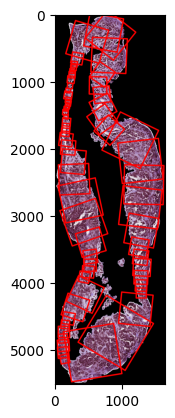

In [7]:
result_image, contour, squares = process_contours(
     image1,
     whole_thresh,
     overlap_thresh=0.4,
     smoothing_size=210,
     look_back=8,
     second_pass=False,
     variable_length=True)

plt.imshow(result_image)

coverage,perc_black_pixels,score=check_metrics(whole_thresh,squares)
print(f'Coverage: {coverage:.2f}%, Percent of mask as blank pixels: {perc_black_pixels:.2f}%, Score: {score:.2f}%')